In [3]:
import matplotlib.pyplot as plt
import estimation_methods as est
import numpy as np

In [4]:
plt.rcParams["figure.figsize"] = (12, 12)

# Testing using synthetic systems

To compare our adaptive filters, we can generate synthetic systems that incorporate various types of perturbations and that feature varying levels of overdeterminedness. 

### Model setup

Consider an arbitrary multivariate signal and its measurement. We denote the system as:

$$\theta_{k+1}=f(x_k,u_k;\theta_k)+v_k$$

and the measurement as:

$$\hat{x}_{k+1}=h(x_k,u_k;\theta_{k})+w_k$$

where $\theta_k\in\mathbb{R}^n$, $x_k\in\mathbb{R}^m$, $v_k\sim\mathcal{N}(0, Q)$, and $w_k\sim\mathcal{N}(0, R)$. (Note: We use $\theta$ and $x$ because we are interested in parameter estimation whereas for state estimation you might use $x$ in the system and $y$ in the measurement.)

Then, we linearize the measurement model with respect to previous parameters $\hat{\theta}_{k-1}$ using a first-order approximation:

$$\hat{x}_{k+1}\approx f(x_k,u_k;\hat{\theta}_{k-1})+\left.\frac{\partial f}{\partial\theta}\right\vert_{\hat{\theta}_{k-1}}(\theta_k-\hat{\theta}_{k-1})+w_k$$

Then, if we let

$$A_k=\left.\frac{\partial f}{\partial\theta}\right\vert_{\hat{\theta}_{k-1}},\quad b_k=\hat{x}_{k+1}-f(x_k,u_k;\hat{\theta}_{k-1})+A_k\hat{\theta}_{k-1}-w_k$$

we can rewrite the linearized measurement form as:

$$A_k\theta_k=b_k.$$


### Adaptive filters

For RLS and DEKA adaptive filters, we can directly estimate the parameters given an initial estimate, the Jacobian of the measurement model with respect to the previous parameter estimate, and the actual measurement. For EKF, however, we must also consider the noise covariance matrices and system model Jacobian. As we do not know a priori what will occur to the system, we assume that the Jacobian of the system is:

$$F_k=\left.\frac{\partial f}{\partial\theta}\right\vert_{\hat{\theta}_{k-1}}=I_n.$$

Similarly, we assume that both system and measurement noise is time invariant. Thus:

$$Q_k=c_1I_n,\quad R_k=c_2I_m$$

for some $c_1\in\mathbb{R}^n$ and $c_2\in\mathbb{R}^m$. This reduces the predicted covariance update step in EKF to:

$$P_{k|k-1}=F_kP_{k-1|k-1}F_k^\mathsf{T}+Q_{k-1}=P_{k-1}+Q_{k-1}$$

For the remaining EKF steps, see the [Wikipedia page](https://en.wikipedia.org/wiki/Extended_Kalman_filter).


### Simulating on synthetic systems

We are interested in not only Gaussian noise but also arbitrary (sudden and gradual) scalings of the parameters. The latter case is of particular interest as we want to simulate how parameters may change in real-life scenarios like if a quadrotor were to pick up a large payload. Traditional adaptive filters should be able to handle these situations but they do not make use of particular inductive biases such as near-overdeterminedness of real-life systems.

To this end, we consider an arbitrary state space model:

$$\theta_{k+1}=\theta_k+v_k$$
$$\hat{x}_{k+1}=F_k\theta_k+w_k$$

In [10]:
class DEKA:
    def __init__(
        self,
        num_params,
        x0=None,
        damping=0.1,
        regularization=1e-6,
        smoothing_factor=0.75,
    ):
        """
        DEKA solver with damping, regularization, and exponential smoothing.

        Args:
            num_params (int): Number of parameters to estimate.
            x0 (np.ndarray): Initial guess for x (num_params x 1). Defaults to zeros.
            damping (float): Damping factor to scale the update (e.g., 0.1).
            regularization (float): Small constant added to denominator for stability.
            smoothing_factor (float): Exponential smoothing factor in [0, 1).
                                      Closer to 1 means more smoothing.
        """
        self.num_params = num_params
        self.x_k = (
            x0.reshape(num_params, 1) if x0 is not None else np.zeros((num_params, 1))
        )
        self.x_k_smooth = self.x_k.copy()
        self.damping = damping
        self.regularization = regularization
        self.smoothing_factor = smoothing_factor

    def iterate(self, A, b, x_0=None, num_iterations=25, tol=0.05):
        """
        Performs DEKA iterations on the system Ax = b using damping and regularization,
        then applies exponential smoothing to the final estimate.

        Args:
            A (np.ndarray): Matrix A (num_rows x num_params).
            b (np.ndarray): Vector b (num_rows x 1).
            x_0 (np.ndarray): Optional new initial guess for x (num_params x 1).
            num_iterations (int): Maximum number of iterations.
            tol (float): Convergence tolerance based on the residual norm.

        Returns:
            np.ndarray: The smoothed solution vector x (num_params x 1).
        """
        if x_0 is not None:
            self.x_k = x_0.reshape(self.num_params, 1)

        # Create a mask to ignore rows where A is all zeros
        row_mask = np.any(A != 0, axis=1)  # True for nonzero rows, False for zero rows
        if not np.any(row_mask):  # If all rows are zero, return x_k immediately
            print("A has only zero rows, returning current estimate.")
            return self.x_k
        A = A[row_mask]  # Keep only nonzero rows
        b = b[row_mask]  # Keep corresponding b values

        for k in range(num_iterations):
            residual = b - A @ self.x_k
            if np.linalg.norm(residual) < tol:
                print(f"tol reached in {k} iterations")
                break

            # Compute quantities needed for the update.
            res_norm_sq = np.linalg.norm(residual) ** 2
            A_row_norms_sq = np.sum(A**2, axis=1) + 1e-10
            max_ratio = np.max(np.abs(residual.flatten()) ** 2 / A_row_norms_sq)
            fro_norm_A_sq = np.linalg.norm(A, "fro") ** 2
            epsilon_k = 0.5 * (max_ratio / res_norm_sq + 1 / fro_norm_A_sq)

            # Determine indices tau_k where the residual is significant.
            tau_k = np.where((residual ** 2).squeeze() / A_row_norms_sq >= epsilon_k * res_norm_sq, 1, 0)
            print(tau_k.sum())

            if tau_k.sum() == 0:
                print("Empty tau_k at iteration", k)
                break

            eta_k = tau_k.reshape(-1, 1) * residual # apply mask to residual

            # Compute the update direction.
            A_T_eta_k = A.T @ eta_k
            denom = np.linalg.norm(A_T_eta_k) ** 2 + self.regularization
            numerator = eta_k.T @ residual
            raw_update = (numerator / denom) * A_T_eta_k

            # Apply damping (scale the update).
            update = self.damping * raw_update

            # Update the raw parameter estimate.
            self.x_k = self.x_k + update

            # if k % 10 == 0 and np.linalg.norm(b - A @ self.x_k) < tol:
            #     print("residual new: ", np.linalg.norm(b - A @ self.x_k))
            #     print("residual previous: ", np.linalg.norm(b - A @ x_prev))
            #     if k < 10:
            #         print("DEKA converged in", k, "iterations")
            #         return self.x_k/3
            #     else:
            #         print("DEKA converged in", k, "iterations")
            #         return self.x_k

        if (k == (num_iterations-1)):
            print("max iter reached")
        # Exponential smoothing to blend the new raw estimate into a smoothed version
        self.x_k_smooth = (
            self.smoothing_factor * self.x_k_smooth
            + (1 - self.smoothing_factor) * self.x_k
        )

        return self.x_k_smooth, k

tol reached in 0 iterations
tol reached in 0 iterations
2
3
4
max iter reached
2
6
3
max iter reached
2
tol reached in 1 iterations
tol reached in 0 iterations
4
1
2
max iter reached
tol reached in 0 iterations
2
3
5
max iter reached
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
4
tol reached in 1 iterations
tol reached in 0 iterations
2
5
3
max iter reached
2
4
4
max iter reached
1
tol reached in 1 iterations
1
5
tol reached in 2 iterations
max iter reached
4
3
1
max iter reached
tol reached in 0 iterations
4
2
3
max iter reached
3
tol reached in 1 iterations
2
tol reached in 1 iterations
tol reached in 0 iterations
5
tol reached in 1 iterations
tol reached in 0 iterations
4
5
3
max iter reached
tol reached in 0 iterations
2
2
1
max iter reached
5
3
1
max iter reached
tol reached in 0 iterations
1
2
2
max iter reached
1
2
1
max iter reached
tol reached in 0 iterations
tol reached in 0 iterati

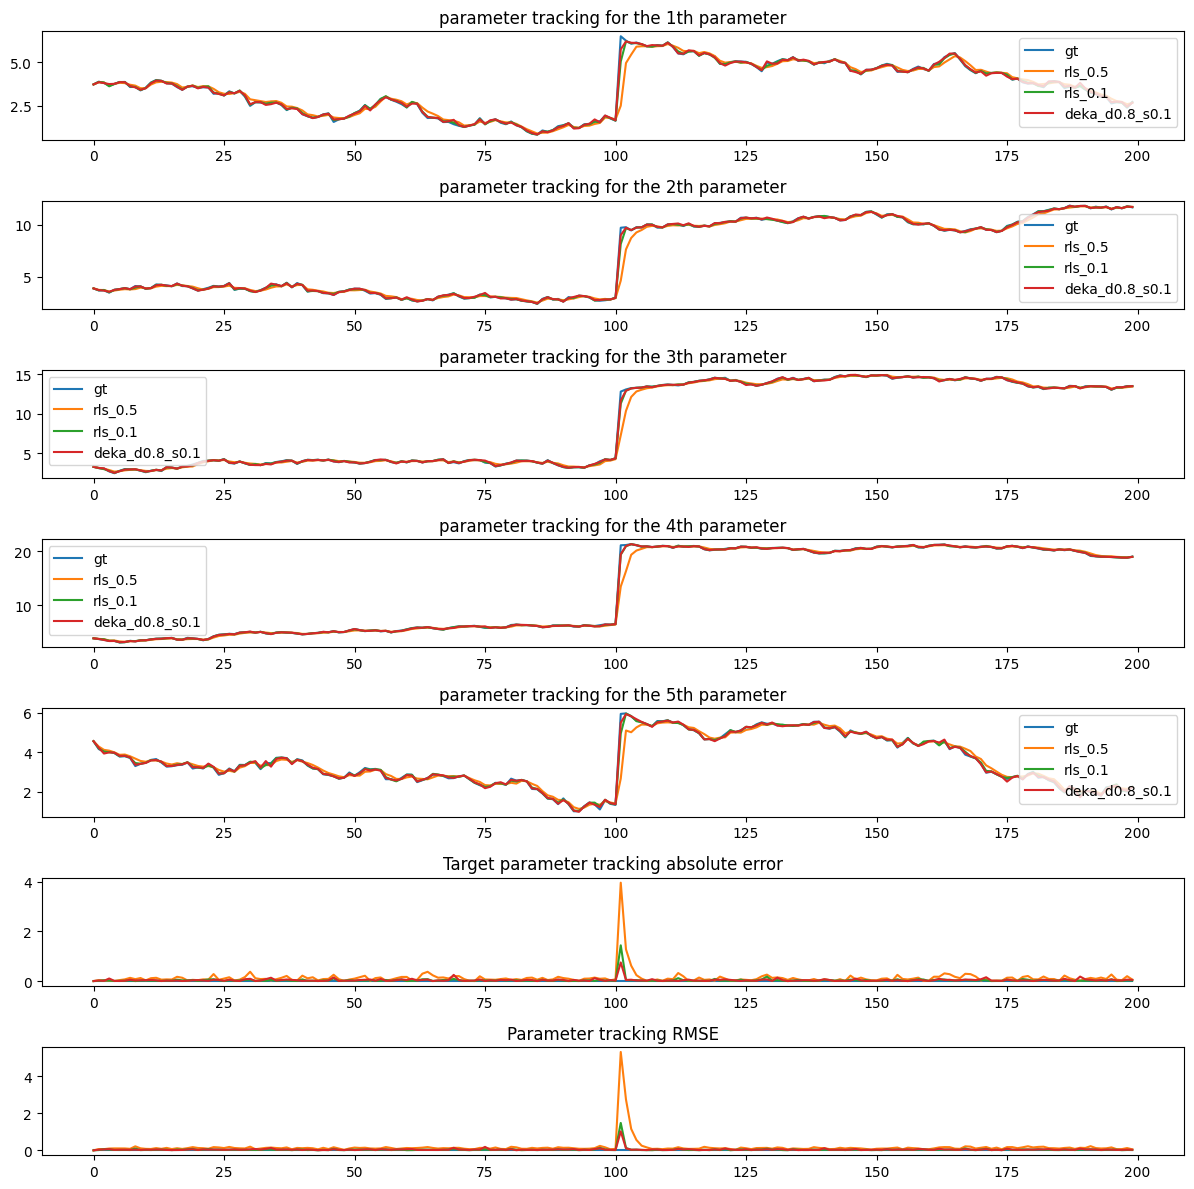

In [16]:

# simulation parameters
d = 20
p = 5

theta_true = np.random.rand(p, 1) # random parameters
# theta_true = np.random.uniform( (p, 1)) # random parameters

filters = {
    # 'ekf': est.EKF(p, np.diag(np.random.normal(0, 0.2, p)), np.diag(np.random.normal(0, 0.1, d))),
    # 'rls_0.9': est.RLS(p, theta_hat=theta_true.copy(), forgetting_factor=0.9),
    'rls_0.5': est.RLS(p, theta_hat=theta_true.copy(), forgetting_factor=0.5),
    'rls_0.1': est.RLS(p, theta_hat=theta_true.copy(), forgetting_factor=0.1),
    # 'arls': est.AdaptiveLambdaRLS(p, forgetting_factor=0.7, alpha=0.1),
    # 'deka_0.9': est.DEKA(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.9),
    'deka_d0.8_s0.1': DEKA(p, x0=theta_true.copy(), damping=0.8, regularization=1e-6, smoothing_factor=0.1)
}

estimate_prev, estimate = theta_true.copy(), theta_true.copy()
estimates = {f: [[] for _ in range(p)] for f in filters.keys()}
actual = [[] for _ in range(p)]
target_se = {f: [] for f in filters.keys()}
total_mse = {f: [] for f in filters.keys()}
num_iters = []

# simulate system
nsim = 200

for k in range(nsim):
    A_k = np.random.randn(d, p)  # random Jacobian (or basically linear transformation)
    b_k = A_k @ theta_true

    if k > 0:

        b_k += np.random.normal(0, 0.1) # measurement noise - 2.5%

    for name, f in filters.items():
        estimate_prev = estimate
        if name ==  'deka_d0.8_s0.1':
            estimate, num_iter = f.iterate(A_k, b_k, estimate_prev, num_iterations=3, tol=0.3)
            num_iters.append(num_iter)
        else:
            estimate = f.iterate(A_k, b_k)
        # print(f"exited {exit_status} at time {k}")

        for i in range(p):
            estimates[name][i].append(estimate[i].item())
        
        target_se[name].append(np.abs(estimate[0] - theta_true[0]).item())
        total_mse[name].append(np.sqrt(np.square(estimate - theta_true).mean()))

    for i in range(p):
        actual[i].append(theta_true[i].item())

    # add perturbation
    theta_true += np.random.normal(0, 0.2, (p, 1)) # process noise - 5%

    # parameter shift
    if k != 0 and k % 100 == 0:
        for i in range(p):
            theta_true[i] *= np.random.uniform(2, 4) # parameter shift - 300%

target_se['gt'] = [0 for _ in range(nsim)]
total_mse['gt'] = [0 for _ in range(nsim)]

# plot results
nplots = p
fig, axs = plt.subplots(nplots + 2)

for i in range(nplots):
    axs[i].plot(actual[i], label='gt')

axs[nplots].plot(target_se['gt'], label='gt')
axs[nplots + 1].plot(total_mse['gt'], label='gt')

for name, vals in estimates.items(): 
    for i in range(nplots):
        axs[i].plot(vals[i], label=name)

    axs[nplots].plot(target_se[name], label=name)
    axs[nplots + 1].plot(total_mse[name], label=name)

for i in range(p):
    axs[i].legend()
    axs[i].set_title(f"parameter tracking for the {i+1}th parameter")
axs[nplots].set_title("Target parameter tracking absolute error")
axs[nplots + 1].set_title("Parameter tracking RMSE")

print(f"mean number of iteration for DEKA: {np.mean(np.array(num_iters))}")

fig.tight_layout()
plt.show()

tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
max iter reached
max iter reached
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
max iter reached
max iter reached
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
max iter reached
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
tol reached in 0 iterations
max iter reached
tol reached in 0 iterations
tol reached in 0 iterations
max iter reached
tol reached i

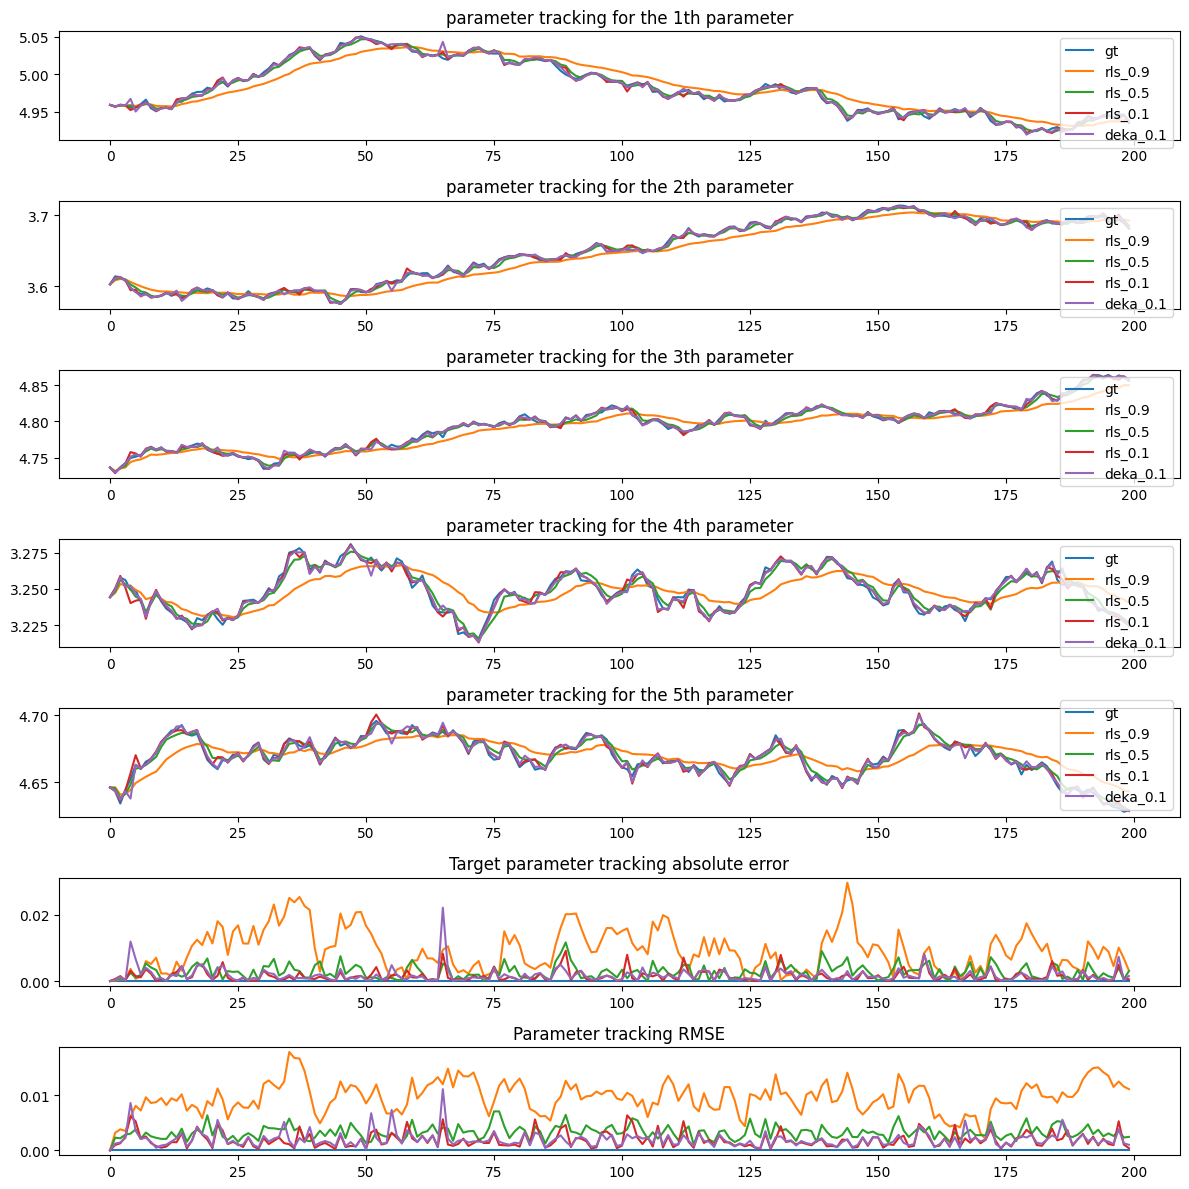

In [ ]:

# # simulation parameters
# d = 20
# p = 5

# theta_true = np.random.uniform(3, 5, (p, 1)) # random parameters

# filters = {
#     # 'ekf': est.EKF(p, np.diag(np.random.normal(0, 0.005, p)), np.diag(np.random.normal(0, 0.005, d))),
#     'rls_0.9': est.RLS(p, theta_hat=theta_true.copy(), forgetting_factor=0.9),
#     'rls_0.5': est.RLS(p, theta_hat=theta_true.copy(), forgetting_factor=0.5),
#     'rls_0.1': est.RLS(p, theta_hat=theta_true.copy(), forgetting_factor=0.1),
#     # 'arls': est.AdaptiveLambdaRLS(p, forgetting_factor=0.7, alpha=0.1),
#     # 'deka_0.9': est.DEKA(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.9),
#     'deka_0.1': DEKA(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.1)
# }

# estimate_prev, estimate = theta_true.copy(), theta_true.copy()
# estimates = {f: [[] for _ in range(p)] for f in filters.keys()}
# actual = [[] for _ in range(p)]
# target_se = {f: [] for f in filters.keys()}
# total_mse = {f: [] for f in filters.keys()}

# # simulate system
# nsim = 200

# for k in range(nsim):
#     A_k = np.random.randn(d, p)  # random Jacobian (or basically linear transformation)
#     b_k = A_k @ theta_true

#     if k > 0:
#         b_k += np.random.normal(0, 0.01) # Noisy measurement

#     for name, f in filters.items():
#         estimate_prev = estimate
#         if name ==  'deka_0.1':
#             estimate = f.iterate(A_k, b_k, estimate_prev, num_iterations=d**2, tol=0.05)
#         else:
#             estimate = f.iterate(A_k, b_k)
#         # print(f"exited {exit_status} at time {k}")

#         for i in range(p):
#             estimates[name][i].append(estimate[i].item())
        
#         target_se[name].append(np.abs(estimate[0] - theta_true[0]).item())
#         total_mse[name].append(np.sqrt(np.square(estimate - theta_true).mean()))

#     for i in range(p):
#         actual[i].append(theta_true[i].item())

#     # add perturbation
#     theta_true += np.random.normal(0, 0.005, (p, 1))

#     # # add major perturbation to parameter 0 only
#     # if k != 0 and k % 100 == 0:
#     #     theta_true[0] *= np.random.uniform(2, 4)

# target_se['gt'] = [0 for _ in range(nsim)]
# total_mse['gt'] = [0 for _ in range(nsim)]

# # plot results
# nplots = p
# fig, axs = plt.subplots(nplots + 2)

# for i in range(nplots):
#     axs[i].plot(actual[i], label='gt')

# axs[nplots].plot(target_se['gt'], label='gt')
# axs[nplots + 1].plot(total_mse['gt'], label='gt')

# for name, vals in estimates.items(): 
#     for i in range(nplots):
#         axs[i].plot(vals[i], label=name)

#     axs[nplots].plot(target_se[name], label=name)
#     axs[nplots + 1].plot(total_mse[name], label=name)

# for i in range(p):
#     axs[i].legend()
#     axs[i].set_title(f"parameter tracking for the {i+1}th parameter")
# axs[nplots].set_title("Target parameter tracking absolute error")
# axs[nplots + 1].set_title("Parameter tracking RMSE")

# fig.tight_layout()
# plt.show()